In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from numpy import mean
import warnings

In [2]:
# Preprocessing function
def pre_process(subject):
    # The list of columns to be dropped
    drop_ls = [
        "expected_time",
        "flip_time",
        "stim_pos",
        "user_pos",
        "lambda_val",
        "change_rate_x",
    ]
    # The feature matrix in array form
    X = subject.drop(columns=drop_ls).to_numpy()

    # Compute the target variable as the difference between user_pos and stim_pos
    y_speed = subject["change_rate_x"].to_numpy()
    y = y_speed

    return X, y

# Function to load all CSV files from a folder
def load_subject_data(folder_path):
    data = []
    subject_id = 1  # Start subject ID counter at 1
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):  # Check if the file is a CSV
            file_path = os.path.join(folder_path, file_name)
            subject_data = pd.read_csv(file_path)
            subject_data['subject_id'] = subject_id  # Assign consecutive subject ID
            data.append(subject_data)
            subject_id += 1  # Increment subject ID for the next file
    return pd.concat(data, ignore_index=True)

# Ridge regression with LOOCV across subjects
def loocv_ridge_across_subjects(data, alpha=1.0):
    unique_subjects = data['subject_id'].unique()
    data_nmae = []
    data_r2 = []

    for test_subject in unique_subjects:
        # Split into train and test by subject
        train_data = data[data['subject_id'] != test_subject]
        test_data = data[data['subject_id'] == test_subject]

        # Preprocess the training and testing data
        X_train, y_train = pre_process(train_data)
        X_test, y_test = pre_process(test_data)

        # Ridge regression model
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Calculate scores
        r2 = r2_score(y_test, y_pred)
        nmae = (-1 * mean_absolute_error(y_test, y_pred))
        data_nmae.append(nmae)
        data_r2.append(r2)

    # Average error across all subjects
    mean_r2 = np.mean(data_r2)
    mean_nmae = np.mean(data_nmae)
    return mean_nmae, data_nmae, mean_r2, data_r2

# Main function
def main_fxn(data_folder_path, data_type):
    # Path to the folder containing the subject files
    folder_path = data_folder_path  # Replace with the path to your folder
    alpha = 0.01  # Regularization parameter for Ridge regression

    # Load data from all CSV files in the folder
    data = load_subject_data(folder_path)

    # Ensure required columns exist in the dataset
    required_columns = [
        "expected_time",
        "flip_time",
        "stim_pos",
        "user_pos",
        "lambda_val",
        "change_rate_x",
    ]
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Missing one or more required columns: {required_columns}")

    # Perform LOOCV across subjects
    mean_nmae, data_nmae, mean_r2, data_r2 = loocv_ridge_across_subjects(data, alpha)

    # Print results
    print(f"Mean R2 across subjects for {data_type}: {mean_r2}")
    print(f"Individual subject R2 Values for {data_type}: {data_r2}")
    print(f"Mean NMAE across subjects for {data_type}: {mean_nmae}")
    print(f"Individual subject NMAE Values for {data_type}: {data_nmae}")

    return mean_nmae, data_nmae, mean_r2, data_r2

In [3]:
DIRECTORY = 'hopkins_export/'  # Adjust this path as needed
MM_DIRECTORY = 'minmax_subjects/'
ZS_DIRECTORY = 'zscore_subjects/'
RS_DIRECTORY = 'robust_subjects/'
raw_mean_nmae, raw_data_nmae, raw_mean_r2, raw_data_r2 = main_fxn(DIRECTORY, 'Raw Data')
mm_mean_nmae, mm_data_nmae, mm_mean_r2, mm_data_r2 = main_fxn(MM_DIRECTORY, 'Min-Max Normalization')
zs_mean_nmae, zs_data_nmae, zs_mean_r2, zs_data_r2 = main_fxn(ZS_DIRECTORY, 'Z-Score Normalization')
rs_mean_nmae, rs_data_nmae, rs_mean_r2, rs_data_r2 = main_fxn(RS_DIRECTORY, 'Robust Scaling Normalization')

Mean R2 across subjects for Raw Data: -0.0007321483437453736
Individual subject R2 Values for Raw Data: [0.0007307056283790692, -0.0009949448754016377, -0.0002319798692604902, -0.0015359640204331004, -0.0004725455514880128, -0.0011425877119444205, 2.7031615017492072e-05, -0.0007475801423821871, -0.0003320085956517449, -0.001727626196621035, -0.00024700484770878717, -0.0025498310900660126, -0.00022691846166722485, 0.0005940358734750628, -0.0006753349923793728, -0.0023461418113763788, -0.0017666935260303163, 0.00023742726245190582, -0.0002524116941307053, 0.00020595673181666996, -0.0004068403298187473, 0.0004905298472137609, -0.012017479307530277, -0.005188901999349627, 0.0008297948859428139, 0.00024177493226595903, -2.145306405809677e-05, -0.0007257642957385624, -0.00077101906923982, 0.0006438431590178872, -0.002531043663486665, 0.00018298886984269291, 0.0015562448408250606, 1.2689206234539618e-05, 0.00034377933264106986, -0.00017025791130431678, -0.0007176660077312658, 0.00134727375324

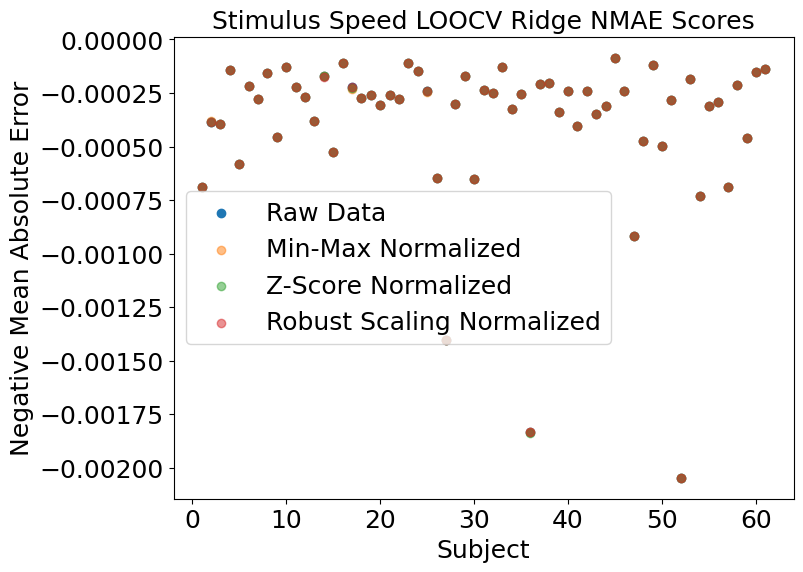

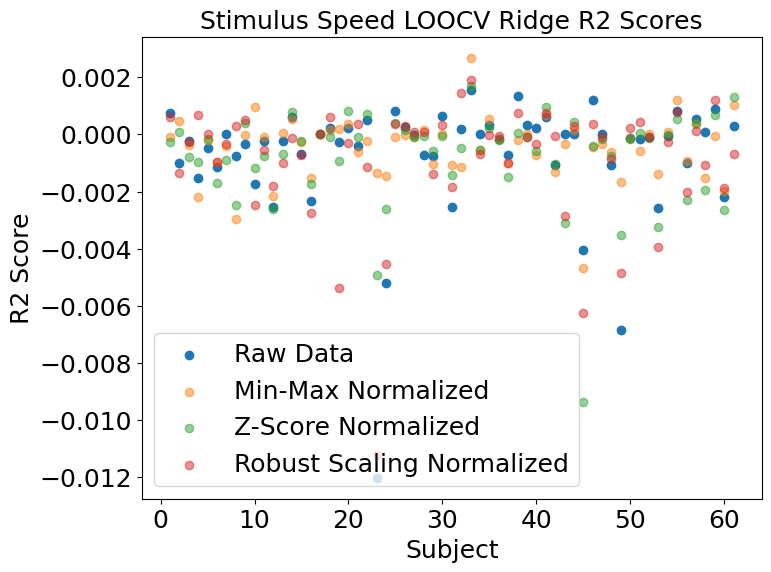

In [5]:
x = np.linspace(1,61,61, dtype = int)

raw_data_r2[16] = 0
zs_data_r2[16] = 0
rs_data_r2[16] = 0
mm_data_r2[16] = 0

plt.figure(figsize=(8,6))
plt.scatter(x, raw_data_nmae, label = 'Raw Data')
plt.scatter(x, mm_data_nmae, label = 'Min-Max Normalized', alpha = 0.5)
plt.scatter(x, zs_data_nmae, label = 'Z-Score Normalized', alpha = 0.5)
plt.scatter(x, rs_data_nmae, label = 'Robust Scaling Normalized', alpha = 0.5)
plt.xlabel('Subject', fontsize = 18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.ylabel('Negative Mean Absolute Error', fontsize = 18)
plt.title('Stimulus Speed LOOCV Ridge NMAE Scores', fontsize = 18)
plt.legend(fontsize = 18)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(x, raw_data_r2, label = 'Raw Data')
plt.scatter(x, mm_data_r2, label = 'Min-Max Normalized', alpha = 0.5)
plt.scatter(x, zs_data_r2, label = 'Z-Score Normalized', alpha = 0.5)
plt.scatter(x, rs_data_r2, label = 'Robust Scaling Normalized', alpha = 0.5)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel('Subject', fontsize = 18)
plt.ylabel('R2 Score', fontsize = 18)
plt.title('Stimulus Speed LOOCV Ridge R2 Scores', fontsize = 18)
plt.legend(fontsize = 18)
plt.show()